### Exploration of results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Source plotting functions
from functions.plotting import signal_shares_lineplot_quarters, signal_shares_lineplot_yearlymean, plot_signal_shares_per_sector, signal_shares_lineplot_per_sector

c:\Users\benny\thesis_environment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../results/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})

# LLM recommendations with only most recent financial statements
llm_recommendations = pd.read_csv("../results/llm_recommendations_final.csv", dtype={"cik": str})

# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)

# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)

# Read in df with info on economic sectors
sectors = pd.read_csv("../data/sp1500_market_sectors.csv", dtype={"cik": str})
sectors = sectors.drop_duplicates(subset=["cik"])

len(llm_recommendations), len(analyst_ratings)

(120860, 355218)

In [3]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates() 

# Determine overlap through merge
shared_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, shared_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, shared_ciks_and_dates, on=["cik", "date"], how="inner"
)
len(llm_recommendations_final), len(analyst_ratings_final)

(113301, 113301)

In [4]:
llm_df = llm_recommendations_final.merge(sectors, on="cik", how="inner")
analyst_df = analyst_ratings_final.merge(sectors, on="cik", how="left")
len(llm_df), len(analyst_df)

(113301, 113301)

In [5]:
llm_df.to_csv("../results/llm_rec_df.csv", index=False)
analyst_df.to_csv("../results/analyst_rec_df.csv", index = False)

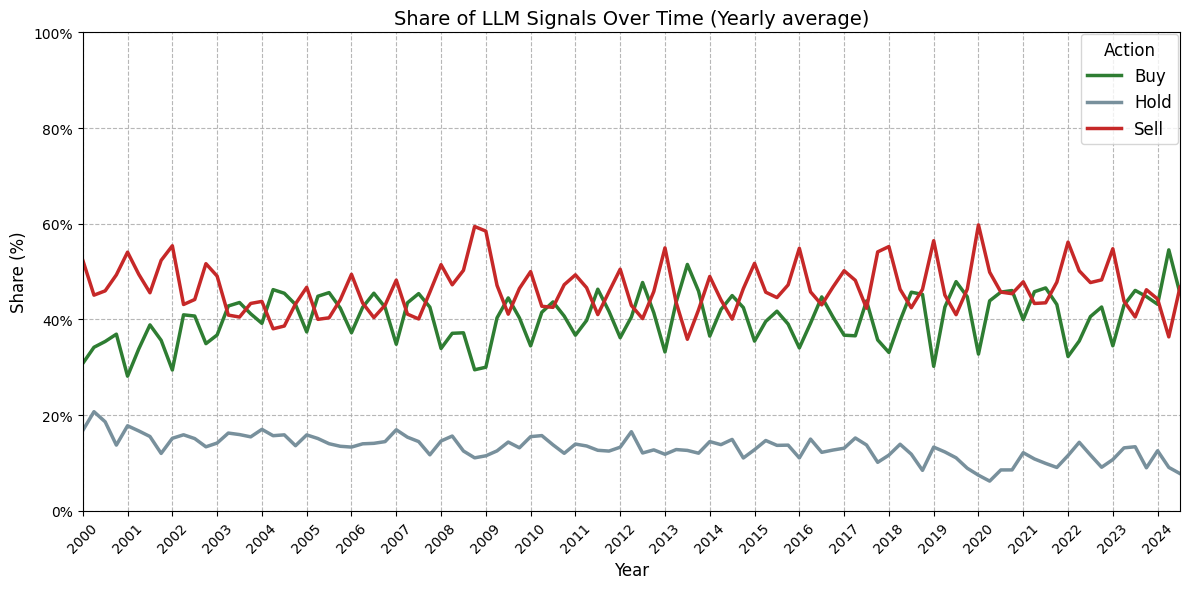

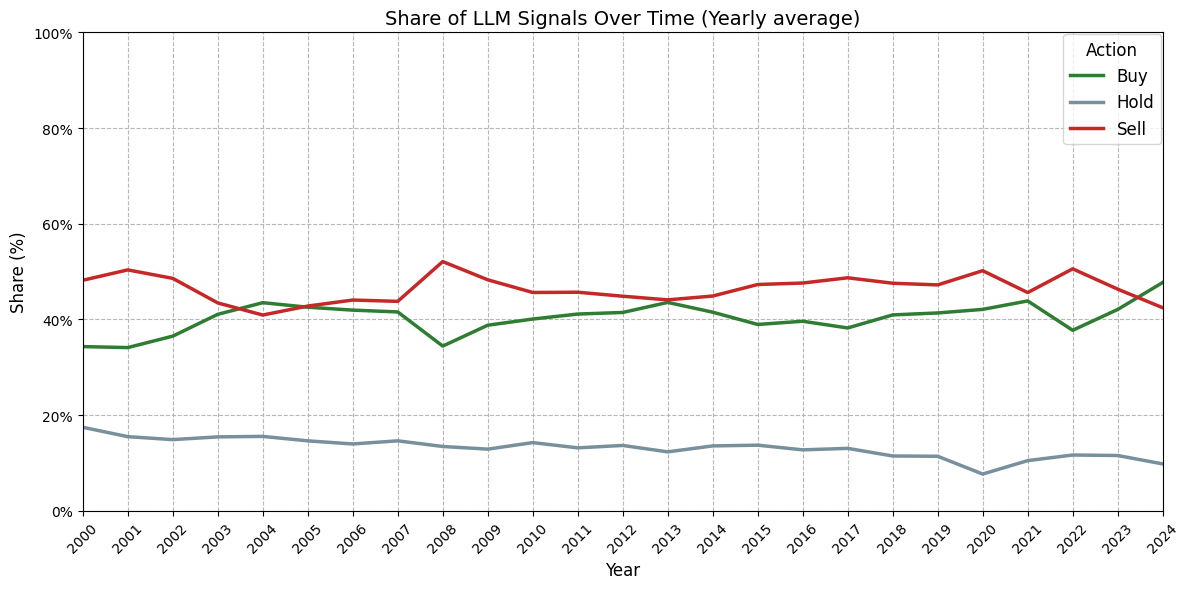

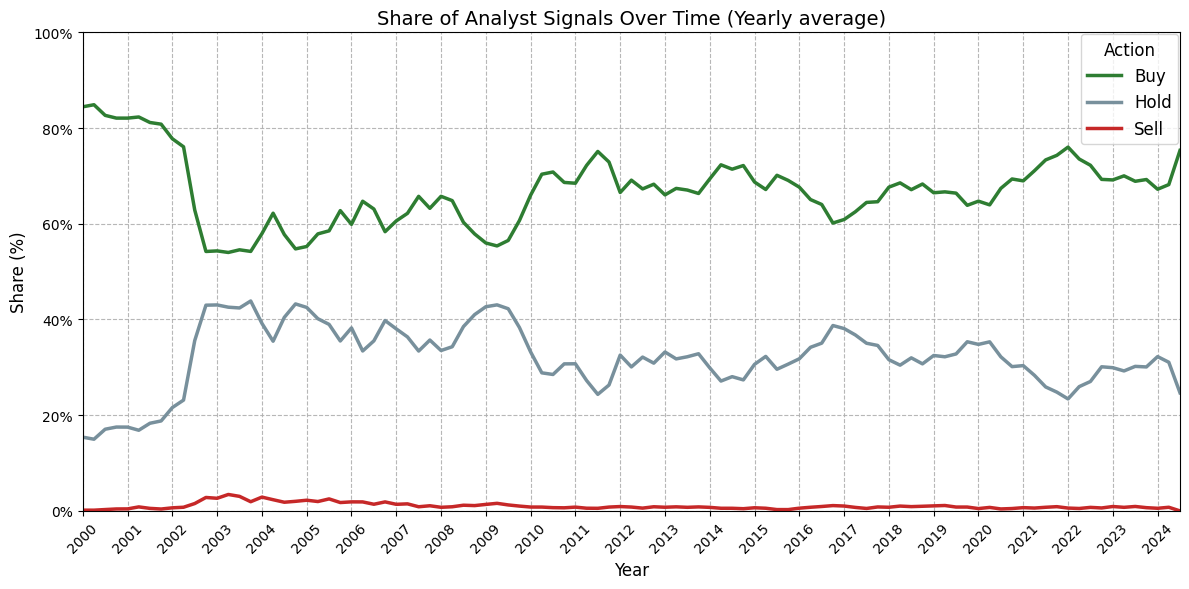

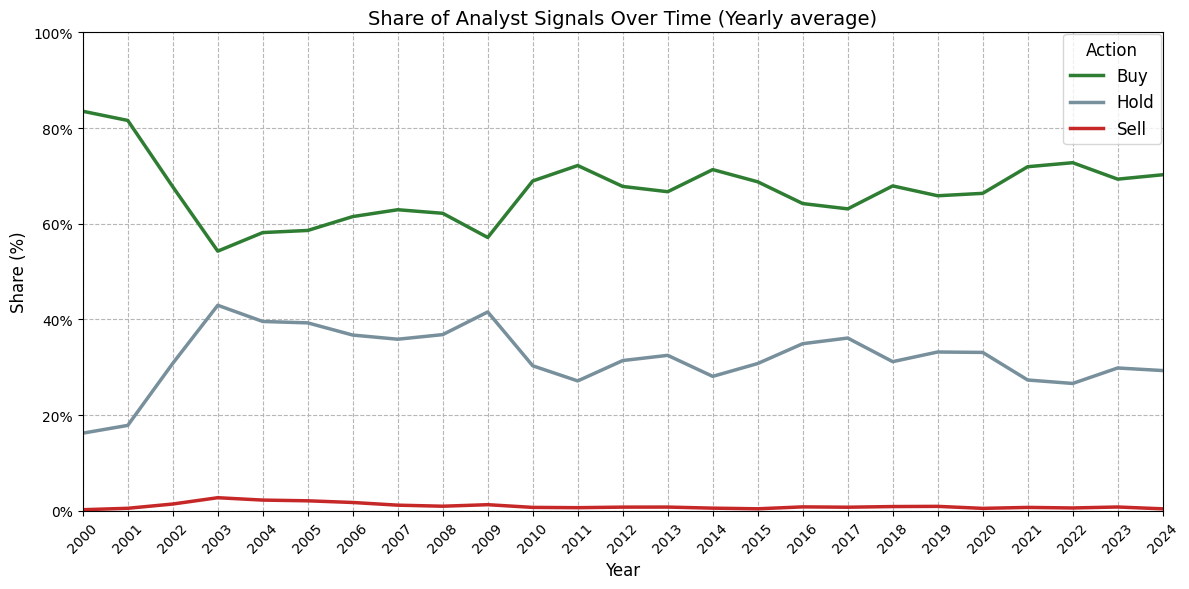

(None, None, None, None)

In [6]:
signal_shares_lineplot_quarters(llm_df), signal_shares_lineplot_yearlymean(llm_df), signal_shares_lineplot_quarters(analyst_df, llm_indicator=False), signal_shares_lineplot_yearlymean(analyst_df, llm_indicator=False)

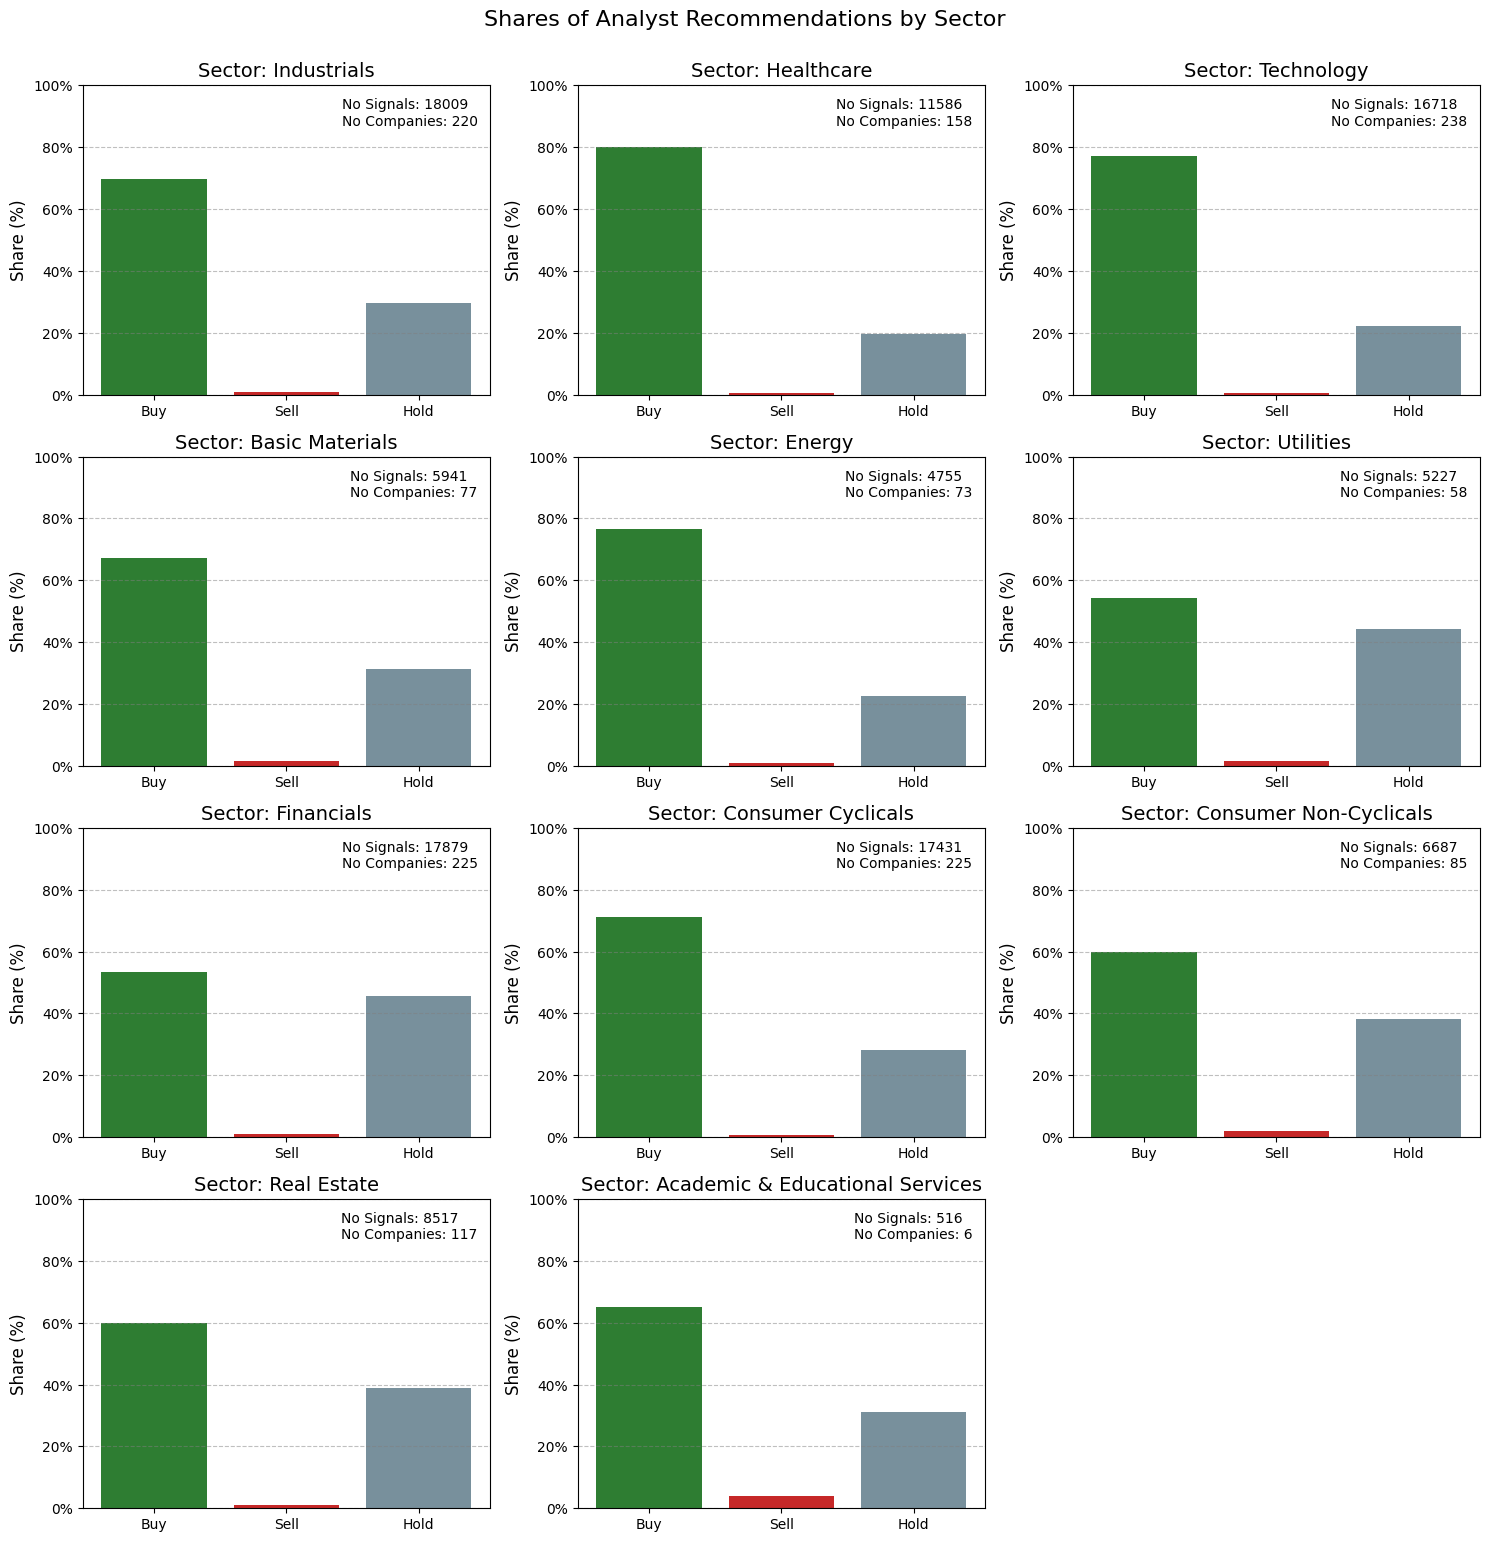

In [7]:
plot_signal_shares_per_sector(analyst_df, llm_indicator = False)

# include number of companies per sector

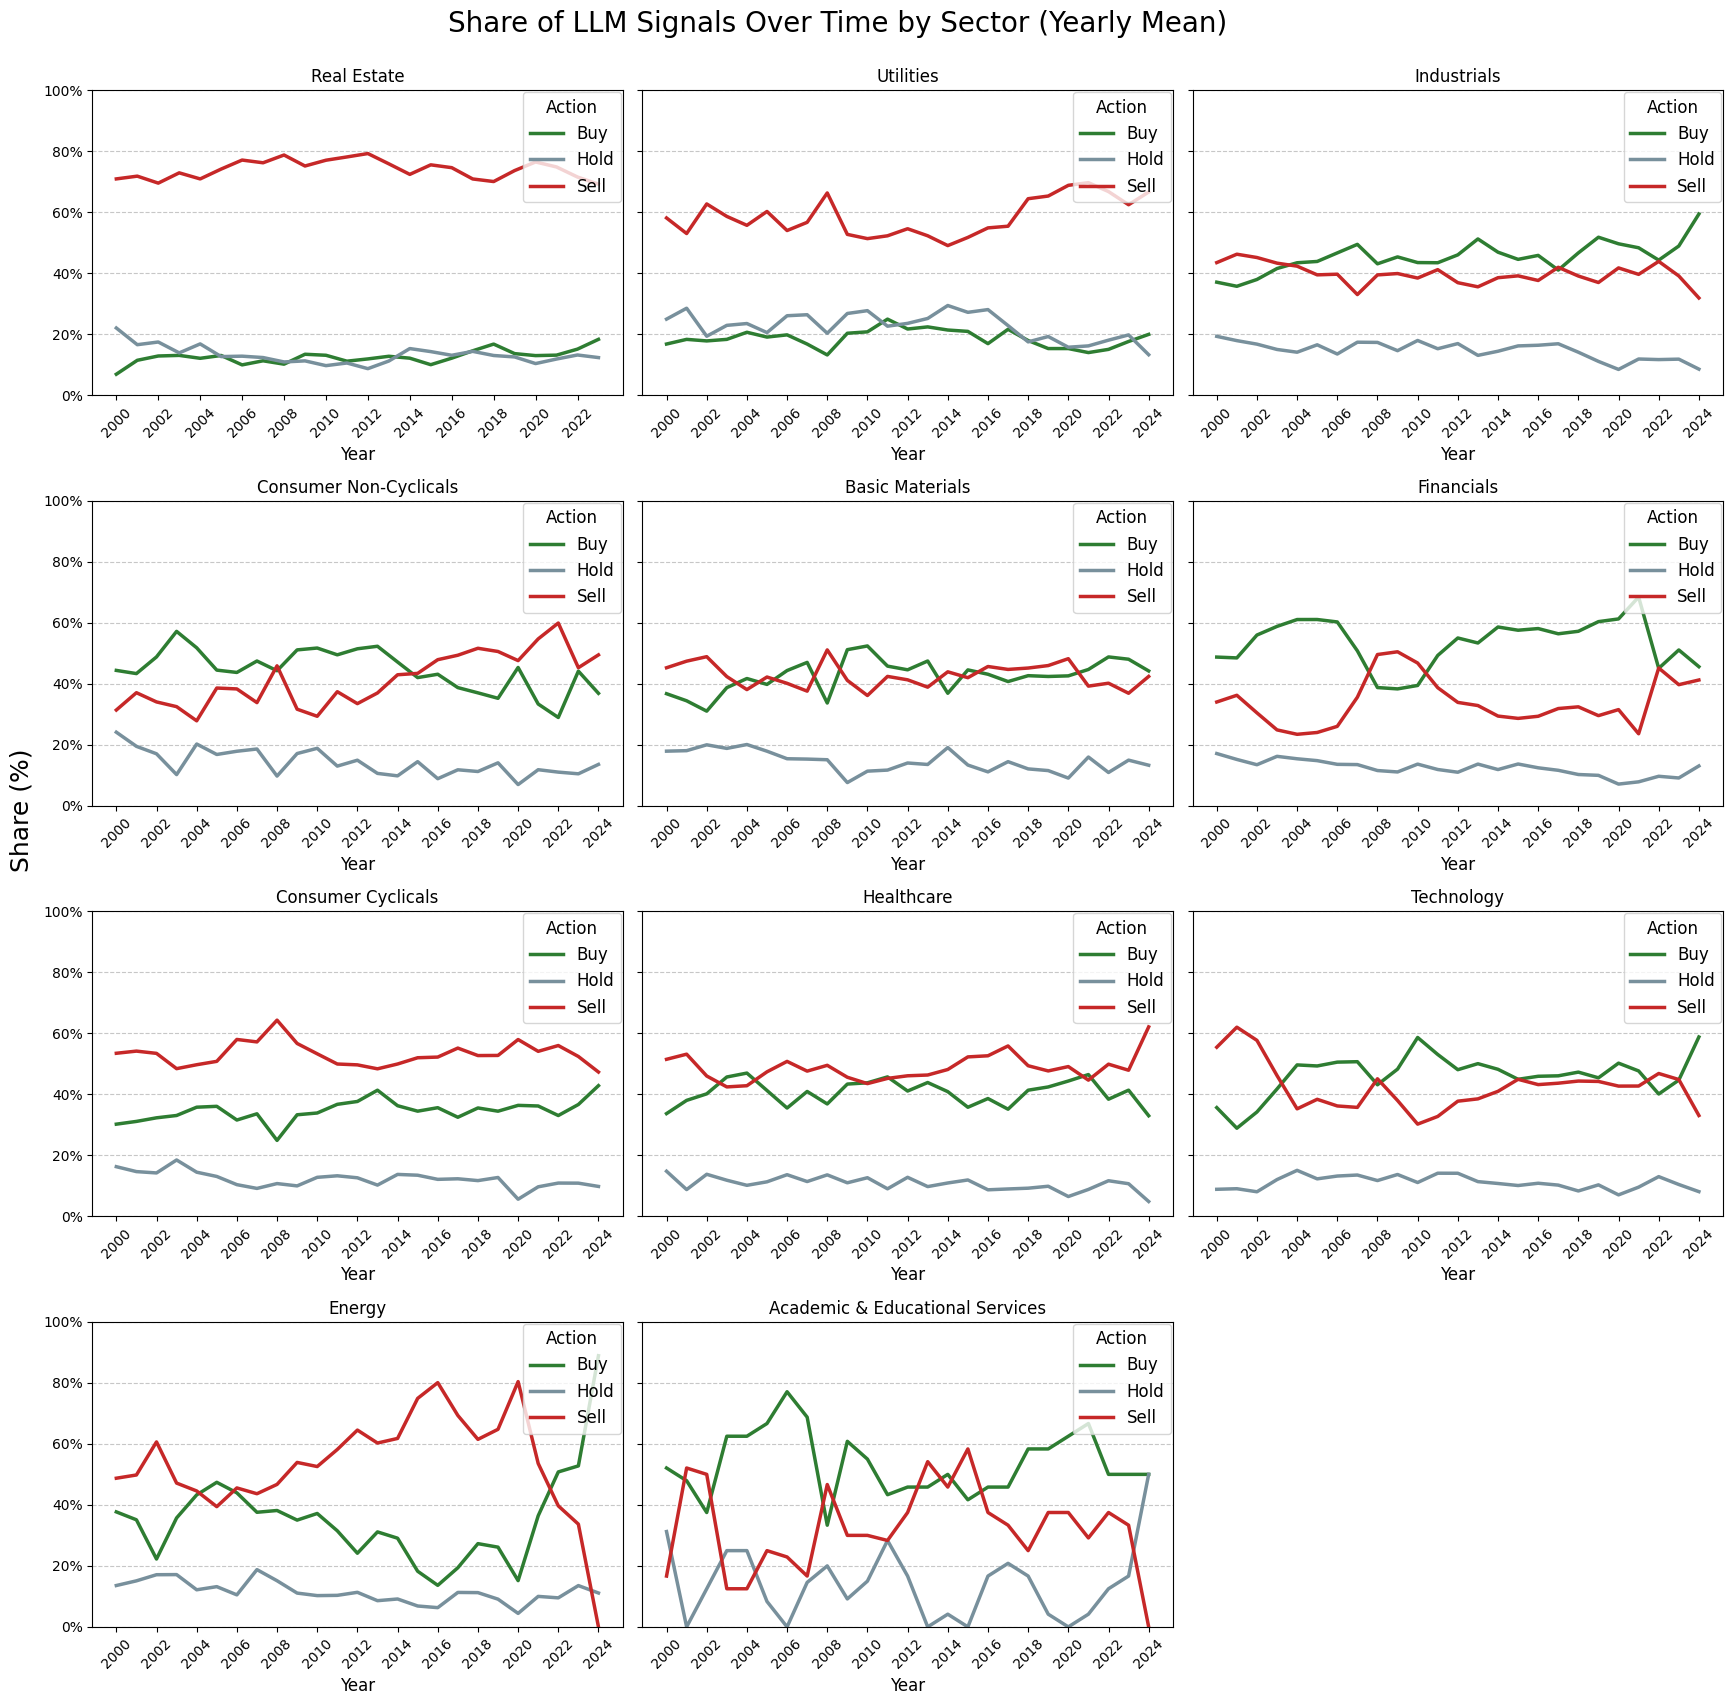

In [8]:
signal_shares_lineplot_per_sector(llm_df, llm_indicator = True)

- Inspection of signal "switches", i.e. how often do analysts/LLMs change their recommendation from their previous one. Is there an anchoring bias?

In [8]:
def count_signal_switches(recommendations_df):
    switches_df = pd.DataFrame(columns=["cik", "n_switches"])
    for cik in recommendations_df["cik"].unique():
        # Subset recommendations for 1 company and sort by date (again, to be safe)
        signals = recommendations_df[recommendations_df["cik"] == cik].sort_values(by="date")[["action", "date", "cik"]].values
        # Count number of switches
        switches = np.sum(signals[1:, 0] != signals[:-1, 0]) 
        # 1: selects everything but the first entry, :-1 everything but the last entry. This effectively shifts the array by one position, allowing for pairwise comparison of consecutive elements.
        # Append to df
        switches_df = pd.concat([switches_df, pd.DataFrame({"cik": [cik], "n_switches": [switches]})], ignore_index=True)
    return switches_df

In [9]:
analyst_switches = count_signal_switches(analyst_df)
llm_switches = count_signal_switches(llm_df)

In [10]:
analyst_switches["n_switches"].sum(), llm_switches["n_switches"].sum()
print(f"From a total of {len(llm_df)} signals, the LLM changed its recommendation {llm_switches['n_switches'].sum()} times ({(llm_switches['n_switches'].sum() / len(llm_df) * 100):.2f}%), while analysts changed their recommendation {analyst_switches['n_switches'].sum()} times ({(analyst_switches['n_switches'].sum() / len(analyst_df) * 100):.2f}%).")
print(f"LLM signals change {llm_switches['n_switches'].sum() / analyst_switches['n_switches'].sum():.2f} times as often as analyst signals.")
print(f"On average, analysts change their recommendation {analyst_switches['n_switches'].mean():.2f} times, while LLMs change their recommendation {llm_switches['n_switches'].mean():.2f} times.")

From a total of 113301 signals, the LLM changed its recommendation 51958 times (45.86%), while analysts changed their recommendation 11342 times (10.01%).
LLM signals change 4.58 times as often as analyst signals.
On average, analysts change their recommendation 7.65 times, while LLMs change their recommendation 35.04 times.


---
## Hypothesis testing on robustness results


The underlying Hypothesis is:

##### - H_0: The returns generated by following the LLM portfolio strategy are smaller or equal to the returns generated by the Analysts' strategy:   r_pf <= r_a

Consequently, the Alternate Hypothesis is:
##### - H_1: The returns generated by following the LLM portfolio strategy are larger than the ones generated by the Analysts' strategy.

Therefore, this represents a one-sided test.

Remarks:
- If t_stat is positive, means of first group is larger than means of second group, i.e. llm_ret > analyst_ret
- P-value then needs to be divided by two to account for one-sided test

- If t_stat was negative, this would be reversed


First check for Normality or use a test that does not assume it i.e. stats.wilcoxon

In [11]:
robustness_results_df_50 = pd.read_csv("../results/robustness_check_results_parallelized_timespan120_sample50_iterations1000_seed1.csv")
robustness_results_df_100 = pd.read_csv("../results/robustness_check_results_parallelized_timespan120_sample100_iterations1000_seed1001.csv")
robustness_results_df_250 = pd.read_csv("../results/robustness_check_results_parallelized_timespan120_sample250_iterations1000_seed2001.csv")
robustness_results_df_500 = pd.read_csv("../results/robustness_check_results_parallelized_timespan120_sample500_iterations1000_seed3001.csv")
robustness_results_df_750 = pd.read_csv("../results/robustness_check_results_parallelized_timespan120_sample750_iterations1000_seed4001.csv")
robustness_results_df = pd.concat([robustness_results_df_50, robustness_results_df_100, robustness_results_df_250, robustness_results_df_500, robustness_results_df_750], ignore_index=True)
robustness_results_df

,simulation,no_companies,start_date,end_date,llm_sr,llm_mean_ret,llm_final_val,analyst_sr,analyst_mean_ret,analyst_final_val,companies
0,1,50,2014-08,2024-08,0.788056,0.197094,6.043440,0.732531,0.189196,5.656342,"['0001420800', '0001699150', '0000825542', '00..."
1,2,50,2011-08,2021-08,0.835363,0.164576,4.588569,1.029264,0.191155,5.750191,"['0000785161', '0001639300', '0000820313', '00..."
2,3,50,2010-05,2020-05,1.064217,0.192461,5.813543,0.820800,0.162315,4.500280,"['0000002488', '0000919012', '0001674862', '00..."
3,4,50,2001-07,2011-07,0.366192,0.081033,2.179669,0.315085,0.066354,1.901131,"['0000850209', '0000866706', '0001324424', '00..."
4,5,50,2004-10,2014-10,1.133942,0.231541,8.025809,0.600192,0.133540,3.502422,"['0000093556', '0000899923', '0001573516', '00..."
...,...,...,...,...,...,...,...,...,...,...,...
4995,996,750,2009-07,2019-07,1.541832,0.270061,10.920545,1.268907,0.219494,7.274389,"['0001600438', '0001490906', '0001576018', '00..."
4996,997,750,2007-07,2017-07,1.030653,0.227442,7.762640,0.832012,0.160745,4.439850,"['0000811596', '0000906107', '0000089089', '00..."
4997,998,750,2007-03,2017-03,1.141227,0.235574,8.292539,0.827676,0.158604,4.358638,"['0000034903', '0001526520', '0001047335', '00..."
4998,999,750,2004-10,2014-10,1.333364,0.291668,12.927381,0.919472,0.187713,5.586192,"['0001039684', '0001996862', '0000887936', '00..."


In [12]:
def shapiro_wilk_test(df):
    diffs = df["llm_mean_ret"] - df["analyst_mean_ret"]
    data = diffs.dropna()
    stat, p_value = stats.shapiro(data)
    return stat, p_value

In [13]:
shapiro_stat_50, shapiro_p_value_50 = shapiro_wilk_test(robustness_results_df_50)
print(f"Sample Size 50: Shapiro-Wilk Test Statistic p-value: {shapiro_p_value_50:.4f}. I therefore {'reject' if shapiro_p_value_50 < 0.05 else 'fail to reject'} the null hypothesis of Normality.")
shapiro_stat_100, shapiro_p_value_100 = shapiro_wilk_test(robustness_results_df_100)
print(f"Sample Size 100: Shapiro-Wilk Test Statistic p-value: {shapiro_p_value_100:.4f}. I therefore {'reject' if shapiro_p_value_100 < 0.05 else 'fail to reject'} the null hypothesis of Normality.")
shapiro_stat_250, shapiro_p_value_250 = shapiro_wilk_test(robustness_results_df_250)
print(f"Sample Size 250: Shapiro-Wilk Test Statistic p-value: {shapiro_p_value_250:.4f}. I therefore {'reject' if shapiro_p_value_250 < 0.05 else 'fail to reject'} the null hypothesis of Normality.")
shapiro_stat_500, shapiro_p_value_500 = shapiro_wilk_test(robustness_results_df_500)
print(f"Sample Size 500: Shapiro-Wilk Test Statistic p-value: {shapiro_p_value_500:.4f}. I therefore {'reject' if shapiro_p_value_500 < 0.05 else 'fail to reject'} the null hypothesis of Normality.")
shapiro_stat_750, shapiro_p_value_750 = shapiro_wilk_test(robustness_results_df_750)
print(f"Sample Size 750: Shapiro-Wilk Test Statistic p-value: {shapiro_p_value_750:.4f}. I therefore {'reject' if shapiro_p_value_750 < 0.05 else 'fail to reject'} the null hypothesis of Normality.")

Sample Size 50: Shapiro-Wilk Test Statistic p-value: 0.0000. I therefore reject the null hypothesis of Normality.
Sample Size 100: Shapiro-Wilk Test Statistic p-value: 0.0000. I therefore reject the null hypothesis of Normality.
Sample Size 250: Shapiro-Wilk Test Statistic p-value: 0.0000. I therefore reject the null hypothesis of Normality.
Sample Size 500: Shapiro-Wilk Test Statistic p-value: 0.0000. I therefore reject the null hypothesis of Normality.
Sample Size 750: Shapiro-Wilk Test Statistic p-value: 0.0000. I therefore reject the null hypothesis of Normality.


In [14]:
def bootstrap_pvalue(df, n_boot=10000, llm_col="mean_llm_ret", analyst_col="mean_analyst_ret"):
    """
    Computes a one-sided bootstrap p-value for the hypothesis:
    H0: LLM <= Analyst
    H1: LLM > Analyst
    
    Parameters:
        df : pandas.DataFrame containing paired returns
        n_boot : number of bootstrap samples
        llm_col : column name for LLM returns
        analyst_col : column name for Analyst returns
    
    Returns:
        p_empirical : one-sided bootstrap p-value
    """
    # First compute the paired differences
    diffs = df[llm_col] - df[analyst_col]
    # Bootstrap sampling, i.e. resampling with replacement of length equal to original sample and then compute mean difference
    # This process is repeated n_boot times and we end up with n_boot mean differences
    boot_means = [np.mean(np.random.choice(diffs, size=len(diffs), replace=True)) for _ in range(n_boot)]
    # Emprical p-value: proportion of bootstrap means less than or equal to 0, i.e. LLM <= Analyst
    # For one-sided test, smaller or equal to 0 is the relevant tail
    # Taking the mean of the boolean array gives the proportion
    p_empirical = np.mean(np.array(boot_means) <= 0)
    return np.round(p_empirical, 50)

In [15]:
bootstrap_pvalues = {
    "N=50": bootstrap_pvalue(robustness_results_df_50, llm_col="llm_mean_ret", analyst_col="analyst_mean_ret"),
    "N=100": bootstrap_pvalue(robustness_results_df_100, llm_col="llm_mean_ret", analyst_col="analyst_mean_ret"),
    "N=250": bootstrap_pvalue(robustness_results_df_250, llm_col="llm_mean_ret", analyst_col="analyst_mean_ret"),
    "N=500": bootstrap_pvalue(robustness_results_df_500, llm_col="llm_mean_ret", analyst_col="analyst_mean_ret"),
    "N=750": bootstrap_pvalue(robustness_results_df_750, llm_col="llm_mean_ret", analyst_col="analyst_mean_ret")
}
bootstrap_pvalues

{'N=50': np.float64(0.0),
 'N=100': np.float64(0.0),
 'N=250': np.float64(0.0),
 'N=500': np.float64(0.0),
 'N=750': np.float64(0.0)}

- Alternative: Conduct Shapiro-Wilk Test to check for Normality of the paired differences
- Then use a paired t-test if normality is not rejected, or a Wilcoxon signed-rank test if normality is rejected.

---
## CAPM Regressions

Factors taken from: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research  
Fama/French 3 Factors downloaded as CSV and preprocessed in Excel.

Benchmark for the CAPM regression will be an equally weighted Portfolio consisting of all S&P 1500 stocks.

In [5]:
# Reading in stock prices and risk free rate 
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})
risk_free_rate_df = pd.read_csv("../data/us3mt_yield_curve.csv")
# Reading in return dataframes
llm_returns = pd.read_csv("../results/final_llm_returns.csv", dtype={"cik": str})
analyst_returns = pd.read_csv("../results/final_analyst_returns.csv", dtype={"cik": str})
# Reading in Fama French factors
ff_factors = pd.read_csv("../data/F-F_Research_Data_Factors_102025.csv", sep = ";")
ff_factors = ff_factors[["Date", "SMB", "HML"]]
# Convert date to YYYY-MM format for merging
ff_factors['Date'] = ff_factors['Date'].apply(lambda x: '-'.join(x.split('-')[::-1]))

In [17]:
# Compute returns
stock_prices = stock_prices.sort_values(['cik', 'date'])
stock_prices['return'] = stock_prices.groupby('cik')['price'].pct_change()
# pct_change() compares each value to the previous one in the same group i.e. cik

In [18]:
# Compute benchmark returns
benchmark_returns = stock_prices.groupby('date')['return'].mean().reset_index()
benchmark_returns.rename(columns={'return': 'benchmark_return'}, inplace=True)
benchmark_returns["benchmark_excess_return"] = benchmark_returns["benchmark_return"] - risk_free_rate_df["monthly_yield"].values
benchmark_returns

,date,benchmark_return,benchmark_excess_return
0,2000-01,0.000000,-0.004550
1,2000-02,0.032436,0.027796
2,2000-03,0.075406,0.070713
3,2000-04,-0.000749,-0.005406
4,2000-05,-0.012498,-0.016999
...,...,...,...
295,2024-08,0.001868,-0.002301
296,2024-09,0.012352,0.008559
297,2024-10,-0.020311,-0.024030
298,2024-11,0.089209,0.085537


In [19]:
# Merge benchmark returns with llm and analyst returns
llm_returns = pd.merge(llm_returns, benchmark_returns, left_on='month', right_on='date', how='left')
analyst_returns = pd.merge(analyst_returns, benchmark_returns, left_on='month', right_on='date', how='left')

# Merge with Fama French factors
llm_returns = pd.merge(llm_returns, ff_factors, left_on='month', right_on='Date', how='left')
analyst_returns = pd.merge(analyst_returns, ff_factors, left_on='month', right_on='Date', how='left')

- ### First Regression with basic CAPM formula, i.e. 

$$
E(R_i) = R_f + \beta_i \left( E(R_m) - R_f \right)
$$

Where:
- $E(R_i)$ = Expected return on the asset, i.e. LLM or Analyst Portfolio 
- $R_f$ = Risk-free rate
- $E(R_m)$ = Expected excess return of the market, as our equally weighted S&P1500 Portfolio
- $\beta_i$ = Beta of the asset (measure of volatility relative to the market)



In [22]:
# LLM CAPM Regression
import statsmodels.api as sm
X = llm_returns["benchmark_excess_return"]
Y_llm = llm_returns["excess_return"]
X = sm.add_constant(X)  # Adds a constant term to the predictor
llm_linear_model = sm.OLS(Y_llm, X).fit()
print(llm_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1584.
Date:                 Fr, 24 Okt 2025   Prob (F-statistic):          1.47e-103
Time:                        14:24:08   Log-Likelihood:                 568.48
No. Observations:                 226   AIC:                            -1133.
Df Residuals:                     224   BIC:                            -1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
# Analyst CAPM Regression
X = llm_returns["benchmark_excess_return"]
Y_analyst = analyst_returns["excess_return"]
X = sm.add_constant(X)  # Adds a constant term to the predictor
analyst_linear_model = sm.OLS(Y_analyst, X).fit()
print(analyst_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     3151.
Date:                 Fr, 24 Okt 2025   Prob (F-statistic):          6.33e-134
Time:                        14:24:08   Log-Likelihood:                 635.62
No. Observations:                 226   AIC:                            -1267.
Df Residuals:                     224   BIC:                            -1260.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [24]:
# Plot regression results
llm_const = llm_linear_model.params['const']
analyst_const = analyst_linear_model.params['const']
llm_beta = llm_linear_model.params['benchmark_excess_return']
analyst_beta = analyst_linear_model.params['benchmark_excess_return']

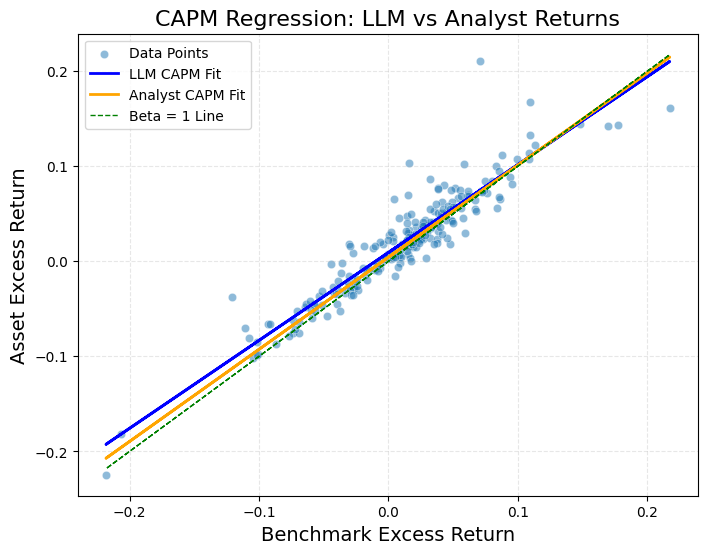

In [25]:
# Simple scatter plot with regression lines
plt.figure(figsize=(8,6))
sns.scatterplot(x=llm_returns["benchmark_excess_return"], y=llm_returns["excess_return"], label="Data Points", alpha=0.5)
plt.plot(llm_returns["benchmark_excess_return"], llm_const + llm_beta * llm_returns["benchmark_excess_return"], color='blue', label='LLM CAPM Fit', linewidth=2)
plt.plot(analyst_returns["benchmark_excess_return"], analyst_const + analyst_beta * analyst_returns["benchmark_excess_return"], color='orange', label='Analyst CAPM Fit', linewidth=2)
# Linear line to show Beta of 1
plt.plot(llm_returns["benchmark_excess_return"], llm_returns["benchmark_excess_return"], color='green', linestyle='--', label='Beta = 1 Line', linewidth=1)
plt.title("CAPM Regression: LLM vs Analyst Returns", fontsize=16)
plt.xlabel("Benchmark Excess Return", fontsize=14)
plt.ylabel("Asset Excess Return", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

- ### Extended Regression with 3-factor model, i.e. 

$$
E(R_i) = R_f + \beta_i \left( E(R_m) - R_f \right) + \beta_{SMB} \cdot SMB + \beta_ {HML} \cdot HML
$$


Where:
- $E(R_i)$ = Expected return on the asset
- $R_f$ = Risk-free rate
- $E(R_m)$ = Expected excess return of the market
- $SMB$ = Small Minus Big (size factor, return of small-cap stocks minus large-cap stocks)  
    Example: A 5% for May 2000 means that small-cap stocks outperformed large-cap stocks by 5% in that month.

- $HML$ = High Minus Low (value factor, return of value stocks minus growth stocks, value stocks have relatively high book to market ratio)  
    Example: A 5% for May 2000 means that, in May 2000, value stocks outperformed growth stocks by 5%.
    
- $\beta_i$ = Beta of the asset (measure of volatility relative to the market)
- $\beta_{SMB}$ = Sensitivity of the asset's return to the SMB factor
- $\beta_ {HML}$ = Sensitivity of the asset's return to the HML factor





In [26]:
X = llm_returns[["benchmark_excess_return", "SMB", "HML"]]
Y_llm = llm_returns["excess_return"]
X = sm.add_constant(X)  # Adds a constant term to the predictor
llm_linear_model = sm.OLS(Y_llm, X).fit()
print(llm_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     553.9
Date:                 Fr, 24 Okt 2025   Prob (F-statistic):          9.25e-103
Time:                        14:24:08   Log-Likelihood:                 574.12
No. Observations:                 226   AIC:                            -1140.
Df Residuals:                     222   BIC:                            -1127.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [27]:
X = analyst_returns[["benchmark_excess_return", "SMB", "HML"]]
Y_analyst = analyst_returns["excess_return"]
X = sm.add_constant(X)  # Adds a constant term to the predictor
llm_linear_model = sm.OLS(Y_analyst, X).fit()
print(llm_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1250.
Date:                 Fr, 24 Okt 2025   Prob (F-statistic):          1.09e-138
Time:                        14:24:08   Log-Likelihood:                 655.00
No. Observations:                 226   AIC:                            -1302.
Df Residuals:                     222   BIC:                            -1288.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

- ## Interpretation

- First of all, all Regression configurations yield a very high $R^2$, indicating a good model fit that is able to explain up to 94% of the observed variance in the data.

- Next, in both Regression scenarios, the Alpha generated by both Portfolios strategies is larger than 0 and statistically significant on any given significance level, with the LLM portfolio outperforming the Analyst's portfolio in either scenario.

- Further, the LLM portfolio exhibits less exposure to market volatility, as seen in the lower coefficient for benchmark_excess_return in both scenarios.
It generally exhibits less exposure to all included factors, when looking at absolute numbers. 

- Looking at the SMB-factor, the LLM Portfolio does not appear to be influenced by it in a way that is statistically significant, while the Analyst's portfolio exhibits a slight exposure to this factor which is significant on the 10% level. 

Since the HML-factor is statistically significant on every conventional significance level for both Portfolios:

- A negative HML-factor, which is significant on every conventional significance level suggests, that both Portfolios favor growth over value stocks

Value Stocks vs. Growth Stocks:

- Value stocks usually have a high book-to-market ratio, meaning they are perceived as undervalued by the market. These are companies with solid, stable earnings and low market prices relative to their book values (e.g., traditional industries like utilities, energy, or some financials).

- Growth stocks, on the other hand, tend to be in sectors with high potential for future growth—companies that are often newer or in industries like technology, biotechnology, or emerging markets, but without a strong focus on current profitability or valuation.

- Given that HML is negative, the portfolio is likely more weighted toward growth-oriented sectors.


---
### Analyzing LLM reasoning 1

In [38]:
import ast
from collections import Counter
# Read in df containing LLM ratings with reasoning
llm_reasoning_df = pd.read_csv("../results/llm_recommendations_with_reasons.csv", dtype={"CIK": str})
# Colnames tolower
llm_reasoning_df.columns = [col.lower() for col in llm_reasoning_df.columns]
# Merge with original LLM ratings df
df = pd.merge(llm_recommendations_final, llm_reasoning_df, on=["cik", "date"], how="right")
# Only keep rows where action is equal to signal
df = df[df["action"] == df["signal"]]
# Use ast.literal_eval to convert the string representation of a list into an actual list
df["reason"] = df["reason"].apply(ast.literal_eval)

df

,cik,date,rating,action,sector,price_to_earnings,book_to_market,interest_coverage,market_capitalization,cash_flow_to_price,...,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,market_cap_to_total_liabilities,sales_to_assets,operating_margin,debt_to_equity,debt_to_assets,signal,reason
0,0001597033,2023-12,sell,sell,Technology,-17.196917,-0.823983,0.385323,1.669717e+09,0.033657,...,0.052198,-0.866486,0.010110,0.276077,0.147051,0.068752,-3.513181,1.034525,sell,[Significant negative net income and comprehen...
3,0001418135,2021-03,buy,buy,Consumer Non-Cyclicals,147.014517,0.497666,5.064286,4.836778e+10,0.006306,...,-0.090471,0.043132,0.014067,1.836844,0.057576,0.244314,0.582817,0.278337,buy,"[Strong positive net income of $325 million., ..."
6,0001609550,2021-06,sell,sell,Healthcare,-402.586672,0.041737,-23.667925,5.269054e+09,-0.002235,...,0.827103,-0.979585,-0.046082,100.758297,0.194553,-0.236862,0.113062,0.091342,sell,[Consistent net losses reported on the income ...
7,0000700923,2018-03,hold,hold,Industrials,89.923379,0.578152,10.202497,5.075275e+08,-0.006386,...,0.306932,0.252404,0.012434,1.702182,0.584206,0.021284,0.241368,0.119718,hold,"[Positive operating cash flow generation., Dec..."
8,0001842022,2021-09,buy,buy,Energy,58.089730,0.891813,3.419355,4.472909e+09,0.021910,...,0.014150,0.049588,0.013043,1.080935,0.026086,0.500000,0.763851,0.374923,buy,[Strong operating cash flow generation ($136M)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20087,0001368514,2020-09,sell,sell,Healthcare,-12.660455,0.333248,-4.464602,2.141827e+08,-0.124871,...,0.647845,-1.689989,-0.072646,1.805923,0.054093,-1.342983,1.359611,0.510820,sell,[Significant net loss reported in the income s...
20093,0000887733,2019-09,buy,buy,Consumer Non-Cyclicals,841.340241,0.608759,1.016754,1.636407e+09,0.061996,...,0.507979,0.208266,0.005364,1.590531,0.267031,0.020089,0.695810,0.342293,buy,"[Strong positive free cash flow generation., S..."
20094,0000887733,2019-09,buy,buy,Consumer Non-Cyclicals,841.340241,0.608759,1.016754,1.636407e+09,0.061996,...,0.507979,0.208266,0.005364,1.590531,0.267031,0.020089,0.695810,0.342293,buy,"[Strong positive free cash flow generation., S..."
20095,0000887733,2019-09,buy,buy,Consumer Non-Cyclicals,841.340241,0.608759,1.016754,1.636407e+09,0.061996,...,0.507979,0.208266,0.005364,1.590531,0.267031,0.020089,0.695810,0.342293,buy,"[Strong positive free cash flow generation., S..."


In [39]:
# Split df by signal
buy_signals_df = df[df["signal"] == "buy"]
sell_signals_df = df[df["signal"] == "sell"]
hold_signals_df = df[df["signal"] == "hold"]

# Flatten reasons into a single list for each signal type
buy_reasons = [reason for sublist in buy_signals_df["reason"] for reason in sublist]
sell_reasons = [reason for sublist in sell_signals_df["reason"] for reason in sublist]
hold_reasons = [reason for sublist in hold_signals_df["reason"] for reason in sublist]

In [40]:
# Count frequency of each reason across all recommendations
buy_reason_counts = Counter(buy_reasons)
sell_reason_counts = Counter(sell_reasons)
hold_reason_counts = Counter(hold_reasons)

buy_reason_counts.most_common(5), sell_reason_counts.most_common(5), hold_reason_counts.most_common(5)

([('Strong positive net income and EPS growth.', 569),
  ('Healthy operating cash flow generation.', 378),
  ('Strong positive free cash flow generation.', 349),
  ('Significant cash and short-term investments.', 317),
  ('Strong positive net income and comprehensive income.', 266)],
 [('Significant net loss reported in the income statement.', 628),
  ('Consistent net losses reported on the income statement.', 277),
  ('Negative Free Cash Flow: The company is generating negative free cash flow, indicating it is not producing enough cash to cover its operating and capital expenditures.',
   266),
  ('Negative earnings per share (EPS) indicating unprofitability.', 226),
  ('High level of debt relative to equity.', 160)],
 [('Positive operating cash flow generation.', 421),
  ('Positive net income and EPS growth.', 229),
  ('Strong operating cash flow generation.', 221),
  ('Significant investment in property, plant, and equipment.', 171),
  ('Significant investment property holdings sugg

In [41]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
# Count individual words in reasons for each signal type without stopwords
buy_vectorizer = CountVectorizer(stop_words='english')
sell_vectorizer = CountVectorizer(stop_words='english')
hold_vectorizer = CountVectorizer(stop_words='english')
X_buy = buy_vectorizer.fit_transform(buy_reasons)
X_sell = sell_vectorizer.fit_transform(sell_reasons)
X_hold = hold_vectorizer.fit_transform(hold_reasons)
buy_word_counts = np.sum(X_buy.toarray(), axis=0)
sell_word_counts = np.sum(X_sell.toarray(), axis=0)
hold_word_counts = np.sum(X_hold.toarray(), axis=0)
buy_word_freq = dict(zip(buy_vectorizer.get_feature_names_out(), buy_word_counts))
sell_word_freq = dict(zip(sell_vectorizer.get_feature_names_out(), sell_word_counts))
hold_word_freq = dict(zip(hold_vectorizer.get_feature_names_out(), hold_word_counts))
sorted(buy_word_freq.items(), key=lambda x: x[1], reverse=True)[:5], sorted(sell_word_freq.items(), key=lambda x: x[1], reverse=True)[:5], sorted(hold_word_freq.items(), key=lambda x: x[1], reverse=True)[:5]

([('cash', np.int64(8163)),
  ('positive', np.int64(5709)),
  ('flow', np.int64(5138)),
  ('strong', np.int64(3524)),
  ('net', np.int64(3511))],
 [('negative', np.int64(13347)),
  ('cash', np.int64(10902)),
  ('flow', np.int64(6432)),
  ('net', np.int64(4841)),
  ('significant', np.int64(4834))],
 [('cash', np.int64(2300)),
  ('flow', np.int64(1724)),
  ('significant', np.int64(1597)),
  ('positive', np.int64(1568)),
  ('debt', np.int64(1304))])

In [42]:
# Bigram analysis
buy_bigram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))
sell_bigram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))
hold_bigram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))

X_buy_bigrams = buy_bigram_vectorizer.fit_transform(buy_reasons)
X_sell_bigrams = sell_bigram_vectorizer.fit_transform(sell_reasons)
X_hold_bigrams = hold_bigram_vectorizer.fit_transform(hold_reasons)

# Sum of bigrams
buy_bigram_counts = np.sum(X_buy_bigrams.toarray(), axis=0)
sell_bigram_counts = np.sum(X_sell_bigrams.toarray(), axis=0)
hold_bigram_counts = np.sum(X_hold_bigrams.toarray(), axis=0)
buy_bigram_freq = dict(zip(buy_bigram_vectorizer.get_feature_names_out(), buy_bigram_counts))
sell_bigram_freq = dict(zip(sell_bigram_vectorizer.get_feature_names_out(), sell_bigram_counts))
hold_bigram_freq = dict(zip(hold_bigram_vectorizer.get_feature_names_out(), hold_bigram_counts))
sorted(buy_bigram_freq.items(), key=lambda x: x[1], reverse=True)[:5], sorted(sell_bigram_freq.items(), key=lambda x: x[1], reverse=True)[:5], sorted(hold_bigram_freq.items(), key=lambda x: x[1], reverse=True)[:5]

([('free cash flow', np.int64(2512)),
  ('short term investments', np.int64(2217)),
  ('cash short term', np.int64(2213)),
  ('cash flow generation', np.int64(2189)),
  ('operating cash flow', np.int64(2153))],
 [('free cash flow', np.int64(2963)),
  ('negative free cash', np.int64(2664)),
  ('operating cash flow', np.int64(2070)),
  ('free operating cash', np.int64(1568)),
  ('high debt levels', np.int64(1321))],
 [('operating cash flow', np.int64(1046)),
  ('positive net income', np.int64(794)),
  ('cash flow generation', np.int64(727)),
  ('net income eps', np.int64(685)),
  ('positive operating cash', np.int64(527))])

In [43]:
# Wordclouds for each signal type
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
def plot_wordcloud(word_freq, title):
    # Create wordcloud with more professional settings
    wordcloud = WordCloud(
        width=1000,  # Increase width for higher resolution
        height=600,  # Increase height for better quality
        background_color='black',  # White background for a clean look
        colormap='Blues',  # Subtle, professional color palette
        max_words=200,  # Limit number of words for more focus
        min_font_size=10,  # Minimum font size to prevent too small words
        max_font_size=100,  # Maximum font size for large words
        contour_width=3,  # Outline around words for better contrast
        contour_color='black',  # Outline color for words
        prefer_horizontal=0.9,  # Higher preference for horizontal words
        random_state=42,  # For reproducibility
    ).generate_from_frequencies(word_freq)
    
    # Create plot with a professional layout
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axis
    plt.title(title, fontsize=18, weight='bold', color='black')  # More prominent title
    plt.tight_layout(pad=0)  # Remove extra padding around the plot
    plt.show()

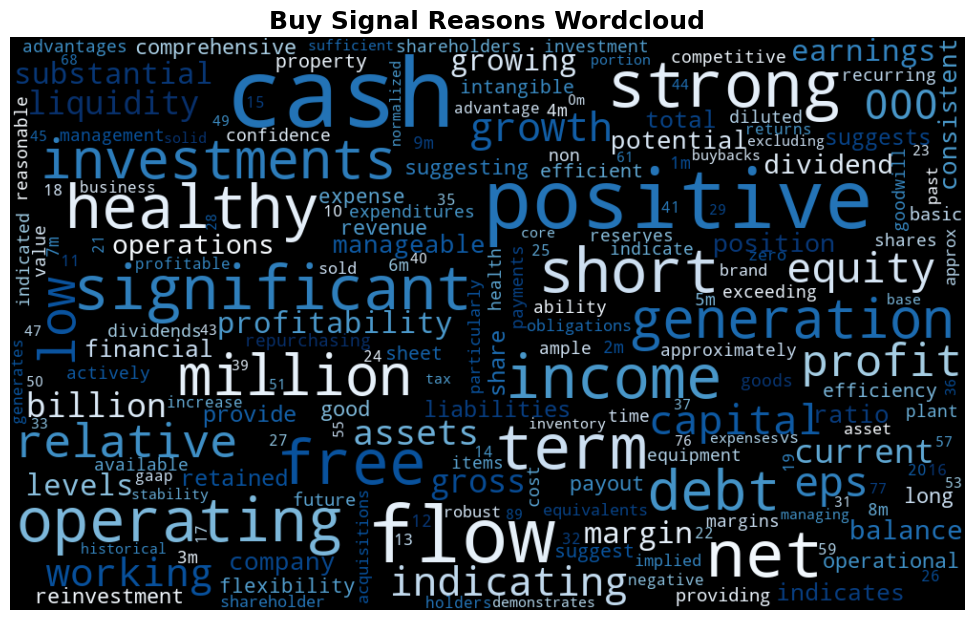

In [44]:
# Buy signal wordcloud
plot_wordcloud(buy_word_freq, "Buy Signal Reasons Wordcloud")

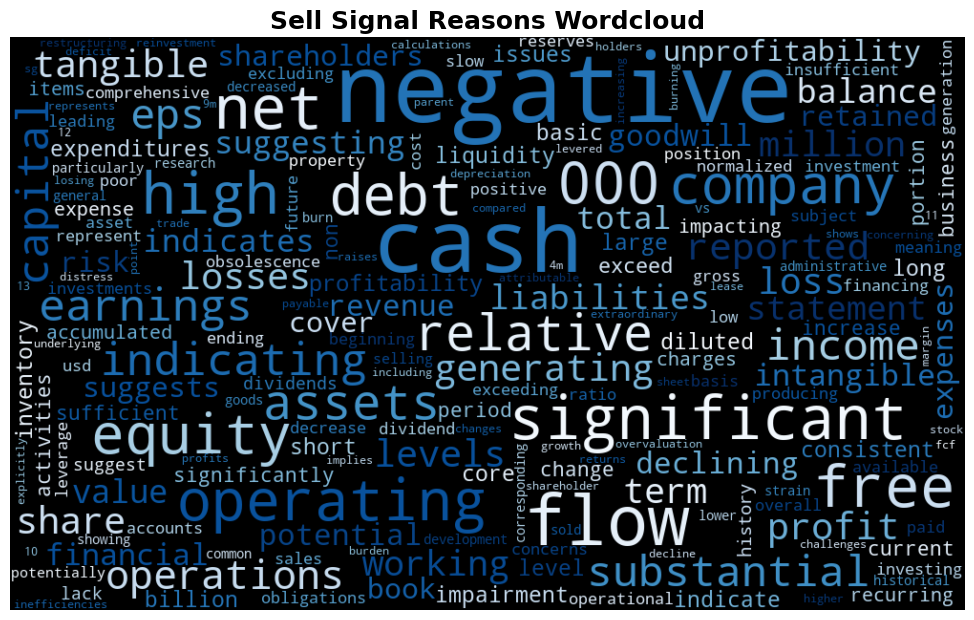

In [45]:
# Sell signal wordcloud
plot_wordcloud(sell_word_freq, "Sell Signal Reasons Wordcloud")

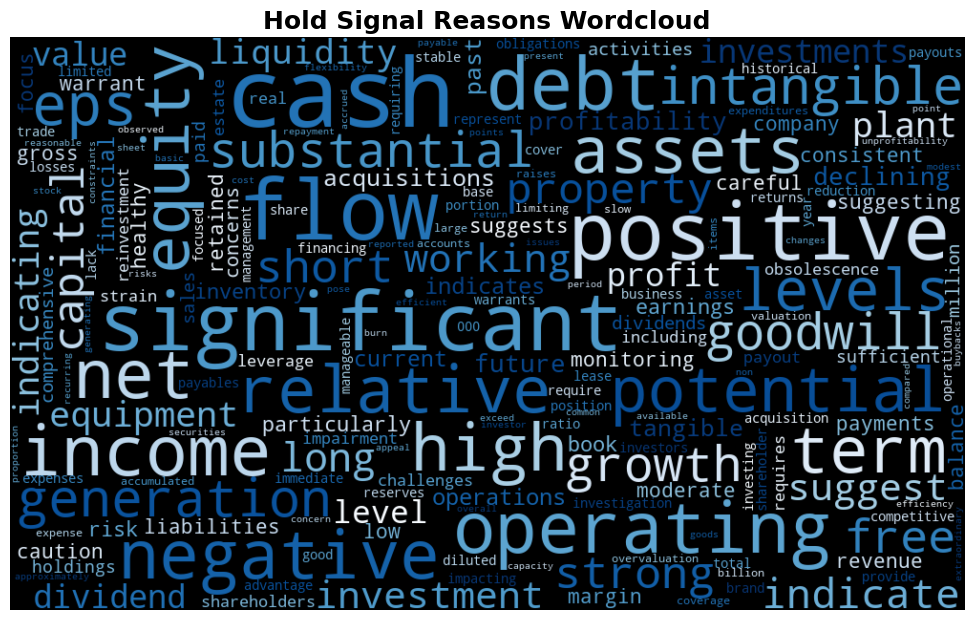

In [46]:
# Hold signal wordcloud
plot_wordcloud(hold_word_freq, "Hold Signal Reasons Wordcloud")

[('free cash flow', np.int64(5867)), ('operating cash flow', np.int64(5269)), ('cash flow generation', np.int64(2958)), ('negative free cash', np.int64(2939)), ('short term investments', np.int64(2527)), ('cash short term', np.int64(2522)), ('positive net income', np.int64(2498)), ('free operating cash', np.int64(2443)), ('significant cash short', np.int64(1840)), ('cash flow equity', np.int64(1819)), ('cash flow operations', np.int64(1763)), ('high debt levels', np.int64(1610)), ('negative working capital', np.int64(1584)), ('net income eps', np.int64(1565)), ('long term debt', np.int64(1436)), ('positive operating cash', np.int64(1391)), ('flow generation significant', np.int64(1352)), ('debt levels relative', np.int64(1336)), ('positive free cash', np.int64(1333)), ('tangible book value', np.int64(1301))]


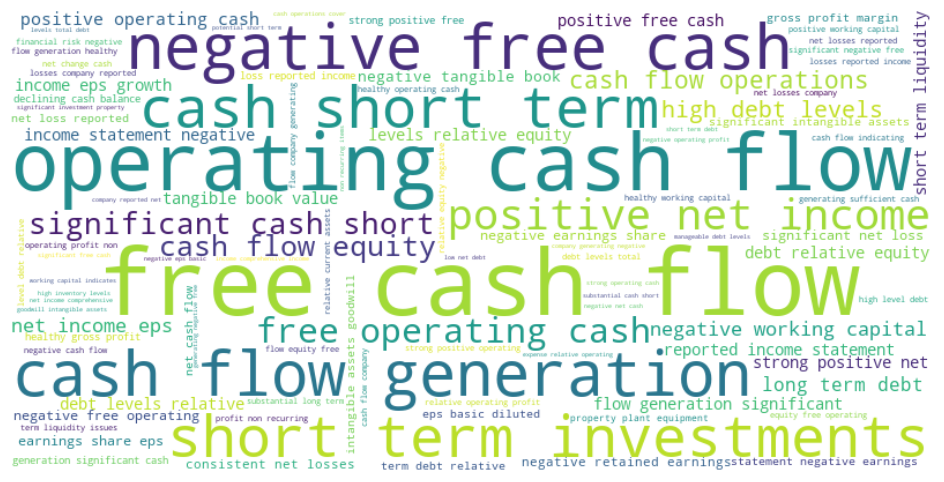

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
sentences = df["reason"].apply(lambda x: ' '.join(x)).tolist()
# Use bigrams
vectorizer = CountVectorizer(ngram_range=(3,3), stop_words='english')
X = vectorizer.fit_transform(sentences)

# Sum counts for each bigram
bigram_counts = X.toarray().sum(axis=0)

# Pair bigram with count and sort
bigrams_freq = sorted(zip(vectorizer.get_feature_names_out(), bigram_counts), key=lambda x: -x[1])

# Top 20 bigrams
print(bigrams_freq[:20])

from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq = dict(bigrams_freq[:100])  # top 50
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(word_freq)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


---
### Analyzing LLM Reasoning 2

Using the computed financial ratios input, instead of the raw financial statements

In [48]:
import pandas as pd 
financial_metric_signals = pd.read_csv("../results/llm_recommendations_with_reasons_from_financial_metrics.csv", dtype={"cik": str})
financial_metric_signals.rename(columns={"Date": "date", "signal": "new_signal"}, inplace=True)
financial_metric_signals

,cik,date,new_signal,reason
0,0000040545,2011-03,sell,"['Cash Flow to Price', 'Return on Equity', 'Ea..."
1,0000884219,2009-06,sell,"['Cash Flow to Price', 'Return on Equity', 'Ea..."
2,0000910108,2012-03,sell,"['Return on Equity', 'Earnings to Price', 'Int..."
3,0001683606,2019-12,sell,"['Cash Flow to Price', 'Return on Equity', 'Ea..."
4,0001133421,2006-06,hold,"['Return on Equity', 'Working Capital to total..."
...,...,...,...,...
19484,0000018230,2008-06,sell,"['Debt to Equity', 'Book to Market', 'Cash Flo..."
19485,0000010456,2021-03,hold,"['Return on Equity', 'Earnings to Price', 'Cas..."
19486,0001579241,2022-09,sell,"['Debt to Equity', 'Book to Market', 'Earnings..."
19487,0001597033,2023-09,sell,"['Interest Coverage', 'Earnings to Price', 'De..."


In [49]:
full_df = financial_metric_signals.merge(llm_df, on=["cik", "date"], how="left")
identical_signals_df = full_df[full_df["action"] == full_df["new_signal"]]

In [50]:
identical_buy_signals_df = identical_signals_df[identical_signals_df["action"] == "buy"]
identical_sell_signals_df = identical_signals_df[identical_signals_df["action"] == "sell"]
identical_hold_signals_df = identical_signals_df[identical_signals_df["action"] == "hold"]

In [51]:
len(identical_buy_signals_df), len(identical_sell_signals_df), len(identical_hold_signals_df)

(1344, 8549, 997)

In [52]:
# Most common reasons for identical buy signals
from collections import Counter
import ast
buy_reasons_df = identical_buy_signals_df["reason"]
buy_reasons = buy_reasons_df.apply(ast.literal_eval)
buy_reasons = [reason for sublist in buy_reasons for reason in sublist]
buy_reason_counts = Counter(buy_reasons)
buy_reason_counts.most_common(10)

[('Interest Coverage', 1324),
 ('Debt to Equity', 1267),
 ('Operating Margin', 1007),
 ('Working Capital to total Assets', 857),
 ('Retained Earnings to total Assets', 668),
 ('Market Cap to total Liabilities', 568),
 ('Return on Equity', 317),
 ('Debt to Assets', 206),
 ('Market Cap to total Liablities', 186),
 ('Book to Market', 75)]

In [53]:
# Most common reasons for identical sell signals
sell_reasons_df = identical_sell_signals_df["reason"]
sell_reasons = sell_reasons_df.apply(ast.literal_eval)
sell_reasons = [reason for sublist in sell_reasons for reason in sublist]
sell_reason_counts = Counter(sell_reasons)
sell_reason_counts.most_common(10)

[('Return on Equity', 8035),
 ('Earnings to Price', 7531),
 ('Cash Flow to Price', 6766),
 ('Interest Coverage', 4875),
 ('Debt to Equity', 3973),
 ('Retained Earnings to total Assets', 2710),
 ('Operating Margin', 2643),
 ('Working Capital to total Assets', 2215),
 ('EBIT to total Assets', 2102),
 ('Book to Market', 1325)]

In [54]:
# Most common reasons for identical hold signals
hold_reasons_df = identical_hold_signals_df["reason"]
hold_reasons = hold_reasons_df.apply(ast.literal_eval)
hold_reasons = [reason for sublist in hold_reasons for reason in sublist]
hold_reason_counts = Counter(hold_reasons)
hold_reason_counts.most_common(10)

[('Return on Equity', 982),
 ('Debt to Equity', 818),
 ('Operating Margin', 757),
 ('Cash Flow to Price', 663),
 ('Earnings to Price', 626),
 ('Interest Coverage', 626),
 ('Working Capital to total Assets', 184),
 ('Retained Earnings to total Assets', 95),
 ('Book to Market', 94),
 ('Market Cap to total Liabilities', 72)]